In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scienceplots
import seaborn as sns

### ЗАДАНИЕ 1

Определение количества успешно сдавших студентов (успешная сдача — это зачёт по курсу на экзамене).

Прочитаем датафреймы с оценками. Посмотрим на уникальные значения поля "code_module"(дисциплины) с типом оценки "Exam".

Таких дисциплин всего 7, и они представлены ниже

In [2]:
df1 = pd.read_csv('assessments.csv')
df1.query(" assessment_type == 'Exam' ").code_module.unique()


array(['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG'], dtype=object)

In [3]:
df2 = pd.read_csv('studentAssessment.csv')
df2

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
...,...,...,...,...,...
173907,37443,527538,227,0,60.0
173908,37443,534672,229,0,100.0
173909,37443,546286,215,0,80.0
173910,37443,546724,230,0,100.0


In [4]:
df3 = pd.read_csv('courses.csv')
df3.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


Посмотрим на датафрейм с предметами. Сгруппируем df3 по номеру семестра и предмету с агрегацией по уникальным значениям продолжительности семестра. В итоге понимаем, что всего имеем 4 семестра. Некотоые дисциплины могут повторяться из семестра в семестр, например дисциплина "ААА" присутствует в 2013J и в 2014J. также каждая отельно взятая дисциплина в каждом семестре имеет свою продолжительность:

In [37]:
df3.groupby(['code_presentation', 'code_module']).agg({'module_presentation_length':'unique'})

module_presentation_length
code_presentation code_module                           
2013B             BBB                              [240]
                  DDD                              [240]
                  FFF                              [240]
2013J             AAA                              [268]
                  BBB                              [268]
                  DDD                              [261]
                  EEE                              [268]
                  FFF                              [268]
                  GGG                              [261]
2014B             BBB                              [234]
                  CCC                              [241]
                  DDD                              [241]
                  EEE                              [241]
                  FFF                              [241]
                  GGG                              [241]
2014J             AAA                              [269]
                  BBB                              [262]
                  CCC                              [269]
                  DDD                              [262]
                  EEE                              [269]
                  FFF                              [269]
                  GGG                              [269]

In [9]:
#df1 - assessments.csv
#df2 - studentAssessment.csv
students_and_exams = \
    df2 \
    .merge(df1.query("assessment_type == 'Exam'"), \
           how = 'inner',
           on = 'id_assessment') \
    .sort_values(['id_student','id_assessment']) \
    .reset_index(drop = True)

students_and_exams['is_exam_passed'] = (students_and_exams['score'] >= 40)
students_and_exams.shape

(4959, 11)

In [6]:
students_and_exams.code_module.unique()

array(['CCC', 'DDD'], dtype=object)

На этом этапе получаем довольно необычный результат. Несмотря на то, что по всем предметам проводится экзамен, студенты сдавали экзамен только по дисциплинам 'CCC' и 'DDD'. Также заметим, что перезачитывались только оценки типа 'CMA' и 'TMA', так что добавление условия 
is_banked == 1 не повлияет на итоговый рез-тат прохождения курса

В рамках этого проекта курсом будем считать предмет, по которому студент сдаёт экзамен. В нашем случае мы будем иметь 4 экзамена по курсу "DDD" и 2 экзамена по курсу 'CCC', так как первый присутствует в каждом семестре, а второй только в двух. 


Остальные дисциплины будем считать факультативами.

In [6]:
students_and_exams \
    .groupby('id_student') \
    .agg({'is_exam_passed': 'sum'}) \
    .value_counts()

is_exam_passed
1                 3802
0                  536
2                  295
dtype: int64

Итого мы получили, что 3802 человека сдали экзамен только по одному предмету

### ЗАДАНИЕ 2

Выявить самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью

In [44]:
#для краткости обозначений скопируем полученный датафрейм в 
#переменную x
#посмотрим на количетсво оценок с разбивкой по семестрам и предметам

x = students_and_exams.copy()
x.groupby(['code_presentation','code_module']).agg({'id_assessment':'count'})



id_assessment
code_presentation code_module               
2013B             DDD                    602
2013J             DDD                    968
2014B             CCC                    747
                  DDD                    524
2014J             CCC                   1168
                  DDD                    950

Посмотрим на курс 'CCC'. Оценим завершаемость экзаменов в рамках курса по двум семестрам: 2014B и 2014J.
Создадим пустой словарь для добавления значений завершаемости:

In [18]:
passing_rate={}
x.query(" code_presentation =='2014B' and code_module == 'CCC' and score >= 40 ")\
    .groupby('id_student').agg({'score':'count'}).reset_index().shape[0]
#664 человека успешно сдали экзамен

664

In [19]:
x.query(" code_presentation =='2014B' and code_module == 'CCC' ")\
    .groupby('id_student').agg({'score':'count'}).reset_index().shape[0]
#всего сдавало экзамен 747 человек

747

In [34]:
c_2014b = round(664/747, 2)
passing_rate['c_2014b'] = c_2014b

In [20]:
x.query(" code_presentation =='2014J' and code_module == 'CCC' and score >= 40 ")\
    .groupby('id_student').agg({'score':'count'}).reset_index().shape[0]
#1019 человека успешно сдали экзамен

1019

In [52]:
x.query(" code_presentation =='2014J' and code_module == 'CCC' ")\
    .groupby('id_student').agg({'score':'count'}).reset_index().shape[0]
#всего сдавало экзамен 1168 человек

1168

In [37]:
c_2014j = round(1019/1168, 2)
passing_rate['c_2014J'] = c_2014j

Аналогично проделаем для курса 'DDD' по всем имеющимся экзаменам, то есть необходимо 
рассмотреть все семестры - 2013B, 2013J, 2014B, 2014J

In [55]:
x.query(" code_presentation =='2013B' and code_module == 'DDD' and score >= 40 ")\
    .groupby('id_student').agg({'score':'count'}).reset_index().shape[0]
#504 человека успешно сдали экзамен

504

In [56]:
x.query(" code_presentation =='2013B' and code_module == 'DDD' ")\
    .groupby('id_student').agg({'score':'count'}).reset_index().shape[0]
#602 человека сдавало экзамен

602

In [40]:
d_2013b = round(504/602, 2)
passing_rate['d_2013B'] = d_2013b

In [57]:
x.query(" code_presentation =='2013J' and code_module == 'DDD' and score >= 40 ")\
    .groupby('id_student').agg({'score':'count'}).reset_index().shape[0]
#878 человека успешно сдали экзамен

878

In [58]:
x.query(" code_presentation =='2013J' and code_module == 'DDD' ")\
    .groupby('id_student').agg({'score':'count'}).reset_index().shape[0]
#968 человек сдавало экзамен

968

In [43]:
d_2013j = round(878/968 ,2)
passing_rate['d_2013J'] = d_2013j

In [59]:
x.query(" code_presentation =='2014B' and code_module == 'DDD' and score >= 40 ")\
    .groupby('id_student').agg({'score':'count'}).reset_index().shape[0]
#485 успешно сдали экзамен

485

In [60]:
x.query(" code_presentation =='2014B' and code_module == 'DDD' ")\
    .groupby('id_student').agg({'score':'count'}).reset_index().shape[0]
#524 человека всего сдавало экзамен

524

In [46]:
d_2014B = round(485/524, 2)
passing_rate['d_2014B'] = d_2014B

In [61]:
x.query(" code_presentation =='2014J' and code_module == 'DDD' and score >= 40 ")\
    .groupby('id_student').agg({'score':'count'}).reset_index().shape[0]
#842 успешно сдали экзамен

842

In [62]:
x.query(" code_presentation =='2014J' and code_module == 'DDD' ")\
    .groupby('id_student').agg({'score':'count'}).reset_index().shape[0]
#950 всего сдавало экзамен

950

In [49]:
d_2014J = round(842/950, 2)
passing_rate['d_2014J'] = d_2014J

In [50]:
passing_rate 

{'c_2014b': 0.89,
 'c_2014J': 0.87,
 'd_2013B': 0.84,
 'd_2013J': 0.91,
 'd_2014B': 0.93,
 'd_2014J': 0.89}

Таким образом, можем сделать вывод, что самая низкая завершаемость наблюдалась в семестре 2013b
у курса 'DDD'('экзамен с id 25340'). Самая высокая завершаемость наблюдалась в семестре 2013J у того же курса 'DDD'
(экз-мен с id 25354)

### ЗАДАНИЕ 3

По каждому предмету определить средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)

In [10]:
dates_of_submission_mean = \
    students_and_exams \
    .query("is_exam_passed") \
    .groupby(['code_module', 'code_presentation', 'id_student'], as_index = False) \
    .agg({'date_submitted': 'max'}) \
    .groupby(['code_module', 'code_presentation']) \
    .agg({'date_submitted': 'mean'}) \
    .apply(lambda x: round(x, 0)) \
    .rename(columns = {'date_submitted': 'date_submitted_mean'})

dates_of_submission_mean

date_submitted_mean
code_module code_presentation                     
CCC         2014B                            232.0
            2014J                            244.0
DDD         2013B                            230.0
            2013J                            240.0
            2014B                            235.0
            2014J                            243.0

#### ЗАДАНИЕ 4

In [11]:
df4 = pd.read_csv('studentRegistration.csv')
df4.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [29]:
df4.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

Найдём топ-3 предмета по регистрации:

In [30]:
df4.groupby(['code_module', 'code_presentation']).agg({'id_student':'nunique'})\
    .rename(columns={'id_student':'registrations'})\
    .sort_values("registrations", ascending=False).head(3)


,,registrations
code_module,code_presentation,
CCC,2014J,2498
FFF,2014J,2365
BBB,2014J,2292


Нйдём топ-3 предмета по отмене:

In [31]:
least_pop = df4.fillna(0) 
least_pop[least_pop['date_unregistration'] < 0 ]

,code_module,code_presentation,id_student,date_registration,date_unregistration
125,AAA,2013J,292923,-162.0,-121.0
136,AAA,2013J,305539,-54.0,-3.0
198,AAA,2013J,405961,-170.0,-100.0
256,AAA,2013J,1763015,-58.0,-2.0
298,AAA,2013J,2318055,-56.0,-19.0
...,...,...,...,...,...
32344,GGG,2014J,679405,-79.0,-66.0
32424,GGG,2014J,685877,-58.0,-58.0
32436,GGG,2014J,686898,-2.0,-1.0
32441,GGG,2014J,687143,-23.0,-3.0


Отрицательные значения в таблице говорят о том, что были ситуации, когда студент записался на курс, но ушёл с него ещё до его начала.

Напомним, что значение NaN в столбце "date_unregistration" соответствует тому, что завершил курс. 

Заменим единичкой все значения в столбце date_unregistration, отличные от нуля. В итоге столбец будет состоять из следующих значений:  
1 - студент покинул курс; 0 - студент дошёл до конца

In [32]:
def replace_val(x): 
    if x != 0:
        return 1
    else:
        return 0

least_pop['date_unregistration'] = least_pop.date_unregistration.apply(replace_val)


In [33]:
least_pop.groupby(['code_module', 'code_presentation']).agg({'date_unregistration':'sum'}).reset_index()\
    .rename(columns={'date_unregistration':'countt'})\
    .sort_values("countt", ascending=False).head(3)


,code_module,code_presentation,countt
7,CCC,2014J,1049
6,CCC,2014B,862
18,FFF,2014J,830


Получили, что больше всего студентов ушло с предметов 'CCC', 'FFF'

### ЗАДАНИЕ 5

Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. 

Продублируем таблицу из второго задания, где демонстрируется количество оценок с разбивкой по семестрам и курсам:

In [50]:
x.groupby(['code_presentation','code_module']).agg({'id_assessment':'count'})

id_assessment
code_presentation code_module               
2013B             DDD                    602
2013J             DDD                    968
2014B             CCC                    747
                  DDD                    524
2014J             CCC                   1168
                  DDD                    950

Из этой таблицы видно, что завершаемость в семестрах 2013B и 2013J 
равна завершаемости соответствующих  курсов, так как в семестрах были проведены экзамены только по одному курсу. 
воспользуемся данными из второго задания для расчёта зав-ти в семестрах с двуми предметами


Для расчёта завершаемости семестров с двумя экзаменами потребуются данные, полученные во 2-ом задании.
Создадим даатафрейм на основе полученных данных: 

In [39]:
pass_rate_by_sem = pd.DataFrame(
    {"success_pass": [504,878,664,485,1019,842],
    "total_pass": [602,968,747,524,1168,950]},
    index = pd.MultiIndex.from_tuples([('2013B', 'DDD'),
                                       ('2013J', 'DDD'),
                                       ('2014B', 'CCC'),
                                       ('2014B', 'DDD'),
                                       ('2014J', 'CCC'),
                                       ('2014J', 'DDD')],
                                      names = ['semester', 'code_module']
                                     
                                     )
)
pass_rate_by_sem

success_pass  total_pass
semester code_module                          
2013B    DDD                   504         602
2013J    DDD                   878         968
2014B    CCC                   664         747
         DDD                   485         524
2014J    CCC                  1019        1168
         DDD                   842         950

In [40]:
pass_rate_by_sem['pass_rate'] = pass_rate_by_sem['success_pass'] / pass_rate_by_sem['total_pass']

pass_rate_by_sem.reset_index().groupby('semester')['pass_rate'].mean()

semester
2013B    0.837209
2013J    0.907025
2014B    0.907231
2014J    0.879374
Name: pass_rate, dtype: float64

Отсюда видно, что семестр 2013b имеет самую низкую завершаемость

Найдём семестр с самой долгой сдачей экзамена. Посмотрим на датафрейм из 3-го задания:

In [48]:
dates_of_submission_mean

date_submitted_mean
code_module code_presentation                     
CCC         2014B                            232.0
            2014J                            244.0
DDD         2013B                            230.0
            2013J                            240.0
            2014B                            235.0
            2014J                            243.0

In [53]:
dates_of_submission_mean.reset_index().drop(columns='code_module').rename(columns={'date_submitted_mean':'mean_submit'})\
        .groupby('code_presentation')\
        .agg({'mean_submit':'mean'})


,mean_submit
code_presentation,
2013B,230.0
2013J,240.0
2014B,233.5
2014J,243.5


Получили, что семестр с самой долгой сдачей экзаменов - 2014J

### Задание 6

Используя python, построить адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. 

Построим адаптированные под задачу обучения RFM-кластеры студентов, где 
- R — среднее время сдачи одного экзамена,
- F — завершаемость курсов,
- M — среднее количество баллов, получаемое за экзамен.

Также стоит сделать важное уточнение. В рамках кластреизации будем делить на группы только тех студентов, которые сдавали курсы. Напомним, что курсом мы считаем дисциплины, по которым:
- существует тип оценки 'Exam';
- студенты сдавали экзамен.

Таким образом, нам подходят только дисциплины 'CCC' и 'DDD'. По сути вся необходимая информация содержится в датайфреймах students_and_exams(задача 1) и dates_of_submission_mean(задача 3), полученным ранее. 


Начнём с разделения по параметру R:


- категория ```1```: студент сдал каждый из своих курсов за время, большее чем среднее время сдачи экзамена для данного курса
- категория ```2```: студент сдал хотя бы один из курсов за время, не превышающее среднее время сдачи экзамена для данного курса

In [12]:
r_score_table = \
    students_and_exams \
    .merge(dates_of_submission_mean.reset_index(), on = ['code_module', 'code_presentation'])

r_score_table

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,is_exam_passed,date_submitted_mean
0,24299,23698,243,0,80.0,CCC,2014J,Exam,NaN,100.0,True,244.0
1,24299,27116,243,0,96.0,CCC,2014J,Exam,NaN,100.0,True,244.0
2,24299,28787,243,0,44.0,CCC,2014J,Exam,NaN,100.0,True,244.0
3,24299,29420,244,0,62.0,CCC,2014J,Exam,NaN,100.0,True,244.0
4,24299,29639,248,0,74.0,CCC,2014J,Exam,NaN,100.0,True,244.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4954,25340,2677955,230,0,69.0,DDD,2013B,Exam,240.0,100.0,True,230.0
4955,25340,2683836,230,0,71.0,DDD,2013B,Exam,240.0,100.0,True,230.0
4956,25340,2689536,229,0,58.0,DDD,2013B,Exam,240.0,100.0,True,230.0
4957,25340,2693243,230,0,82.0,DDD,2013B,Exam,240.0,100.0,True,230.0


In [10]:
students_and_exams.is_exam_passed.value_counts()

True     4392
False     567
Name: is_exam_passed, dtype: int64

In [11]:
students_and_exams.query(" is_exam_passed != True ")

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,is_exam_passed,date_submitted_mean
15,24299,72609,245,0,24.0,CCC,2014J,Exam,NaN,100.0,False,244.0
21,24299,109577,245,0,26.0,CCC,2014J,Exam,NaN,100.0,False,244.0
24,24299,120236,244,0,26.0,CCC,2014J,Exam,NaN,100.0,False,244.0
30,24299,138997,245,0,30.0,CCC,2014J,Exam,NaN,100.0,False,244.0
33,24299,145114,244,0,22.0,CCC,2014J,Exam,NaN,100.0,False,244.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4911,25340,2381845,230,0,27.0,DDD,2013B,Exam,240.0,100.0,False,230.0
4923,25340,2499307,231,0,20.0,DDD,2013B,Exam,240.0,100.0,False,230.0
4941,25340,2611779,230,0,24.0,DDD,2013B,Exam,240.0,100.0,False,230.0
4949,25340,2655683,230,0,33.0,DDD,2013B,Exam,240.0,100.0,False,230.0


In [13]:
def set_category_R(date_submitted, date_submitted_mean) :

    if date_submitted >= date_submitted_mean :
        category = 1
    else :
        category = 2
        
    return category


In [68]:
r_score_table['R_score'] = \
    r_score_table\
    .apply(lambda x: set_category_R(x.date_submitted, x.date_submitted_mean),
           axis = 1)
#students_and_exams.category_R.unique()
r_score = r_score_table.groupby('id_student', as_index = False).agg({'R_score': max})
r_score

,id_student,R_score
0,23698,2
1,24213,1
2,27116,2
3,28046,2
4,28787,2
...,...,...
4628,2694886,1
4629,2694933,1
4630,2695608,2
4631,2697181,2


Теперь разделим данные по параметру F. 

В данном случае кластеры будут аналогичным результату задачи 1:

- категория ```0```: студент пытался сдать курсы, но не сдал ни один из курсов;
- категория ```1```:  студент начал 1 или более курсов но завершил только один;
- категория ```2```: студент начал и завершил два курса (или более -- хотя в наших данных максимум это два курса).

In [69]:
f_score = \
    students_and_exams \
    .groupby('id_student') \
    .agg({'is_exam_passed': 'sum'}) \
    .rename(columns = {'is_exam_passed': 'F_score'}) \
    .reset_index()
f_score['F_score'] = f_score['F_score'].astype(int)
f_score

,id_student,F_score
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1
...,...,...
4628,2694886,1
4629,2694933,1
4630,2695608,1
4631,2697181,1


In [70]:
f_score.F_score.value_counts()

1    3802
0     536
2     295
Name: F_score, dtype: int64

Теперь разделим данные по параметру M(среднее кол-во баллов за экзамен):

- категория ```0```: mean_score < 40 - неудовл. оценка
- категория ```1```:  40 <= mean_score < 0.5 квантиль(медиана) - удовл. оценка
- категория ```2```: 0.5 квантиль(медиана) <= mean_score < 0.8 квантиль - хороший результат
- категория ```3```: 0.8 квантиль(медиана) <= mean_score  - отличный результат

In [63]:
m_score_table = students_and_exams.groupby('id_student', as_index=False).agg({'score':'max'})
m_score_table

,id_student,score
0,23698,80.0
1,24213,58.0
2,27116,96.0
3,28046,40.0
4,28787,44.0
...,...,...
4628,2694886,69.0
4629,2694933,73.0
4630,2695608,73.0
4631,2697181,80.0


In [53]:
first_quant, second_quant = students_and_exams.score.quantile(q=[0.5, 0.8])

In [54]:
def set_category_M(score):
    if score < 40:
        category = 0
    elif score >=40 and score <= first_quant:
        category = 1
    elif score > first_quant and score <= second_quant:
        category = 2
    elif score > second_quant:
        category = 3
    return category

In [65]:
m_score_table['M_score'] = students_and_exams.apply(lambda x: set_category_M(x.score), axis = 1)
m_score = m_score_table.drop('score', axis = 1)
m_score

,id_student,M_score
0,23698,2
1,24213,1
2,27116,3
3,28046,1
4,28787,1
...,...,...
4628,2694886,3
4629,2694933,2
4630,2695608,3
4631,2697181,1


In [76]:
#Теперь соберём всё в одной сводной таблице: 

full_data = r_score.merge(f_score, how='inner', on='id_student').merge(m_score, how='inner', on='id_student')
full_data

,id_student,R_score,F_score,M_score
0,23698,2,1,2
1,24213,1,1,1
2,27116,2,1,3
3,28046,2,1,1
4,28787,2,1,1
...,...,...,...,...
4628,2694886,1,1,3
4629,2694933,1,1,2
4630,2695608,2,1,3
4631,2697181,2,1,1


In [77]:
full_data['RMF Score'] = full_data['R_score'].map(str) + full_data['M_score'].map(str) +full_data['F_score'].map(str)
full_data.head()

,id_student,R_score,F_score,M_score,RMF Score
0,23698,2,1,2,221
1,24213,1,1,1,111
2,27116,2,1,3,231
3,28046,2,1,1,211
4,28787,2,1,1,211


Разделение на сегменты даёт нам 2x4x3=24 сегмента. Довольно много сегментов. Я буду работать с 5 сегментами. Ниже представлено описание этих сегментов: 
- ```гедонисты ``` : сдали быстрее всех, чтобы скинуть предмет и заниматься более полезными делами. Кому-то из инх повезло больше(прошли порог), а кому-то меньше(не прошли порог);

- ``` раздолбы ```: тянули до делайна. сделали всё в последний момент. Как и в случае гедонистов кто-то получил уд, а кто-то неуд;

- ``` продуктивные ребята ```: быстро сдали  экзамен по курсу и получили хороший и отличный результат;

- ``` будущий отличник ```: долго сидел над подготовкой, но чуть-чуть не хватило до отла. возможно, поздно сел за предмет или просто не смог учесть всех подводных камней при подготовке;

- ```супер-трудяга ```: долго сидел и в итоге получил заслуженный отл. 


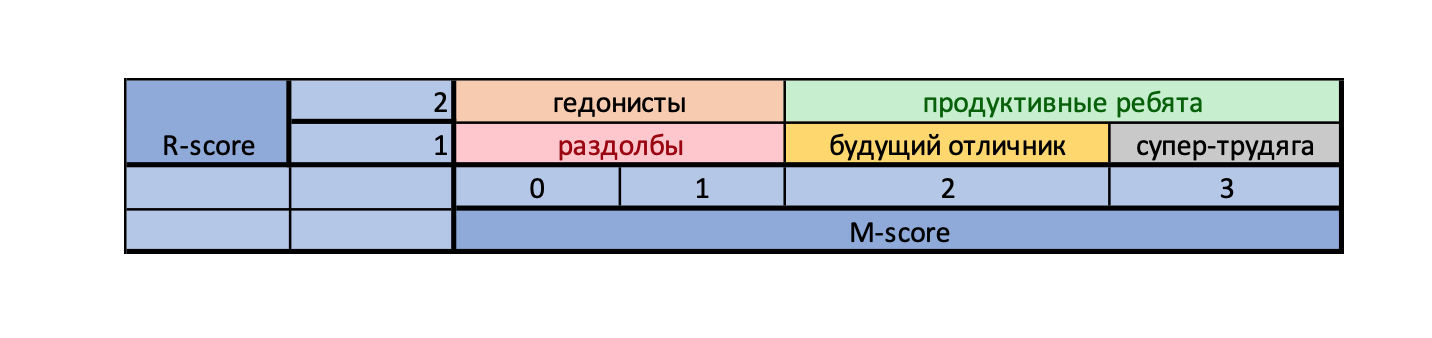

In [74]:
from PIL import Image

img = Image.open('Снимок экрана 2023-03-29 в 23.46.02.png')
img.show()


In [82]:
segt_map = {
    r'1[0-1]': 'раздолбы',
    r'2[0-1]': 'гедонисты',
    r'2[2-3]': 'продуктивные ребята',
    r'12': 'будущий отличник',
    r'13': 'супертрудяга',
}

full_data['segment'] = full_data['R_score'].map(str) + full_data['F_score'].map(str)
full_data['segment'] = full_data['segment'].replace(segt_map, regex=True)
full_data

,id_student,R_score,F_score,M_score,RMF Score,Segment,segment
0,23698,2,1,2,221,гедонисты,гедонисты
1,24213,1,1,1,111,раздолбы,раздолбы
2,27116,2,1,3,231,гедонисты,гедонисты
3,28046,2,1,1,211,гедонисты,гедонисты
4,28787,2,1,1,211,гедонисты,гедонисты
...,...,...,...,...,...,...,...
4628,2694886,1,1,3,131,раздолбы,раздолбы
4629,2694933,1,1,2,121,раздолбы,раздолбы
4630,2695608,2,1,3,231,гедонисты,гедонисты
4631,2697181,2,1,1,211,гедонисты,гедонисты


In [ ]:
full_data.segment.unique()

# супер-трудяг в нашем случае не наблюдается

Построим распределение параметров кластеризации:

Text(0.5, 1.0, 'M-score')

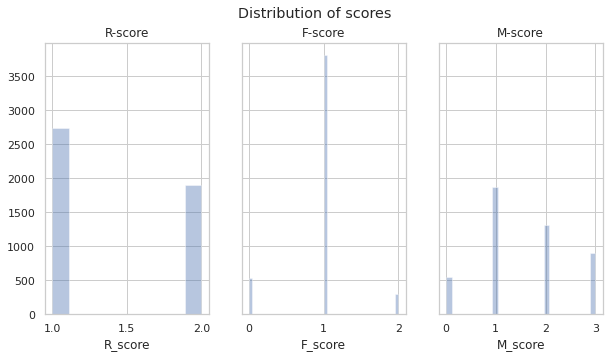

In [108]:


sns.set(style='whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
fig.suptitle('Distribution of scores')

# R-score
sns.distplot(full_data.R_score,ax=axes[0] ,kde=False)
axes[0].set_title('R-score')

# F-score
sns.distplot(full_data.F_score,ax=axes[1] ,kde=False)
axes[1].set_title('F-score')

# M-score
sns.distplot(full_data.M_score, ax=axes[2] ,kde=False)
axes[2].set_title('M-score')

Вывод:

В основном студенты сдавали экзамен дольше среднего, получали удовлетворительный результат, сдавали один предмет. 

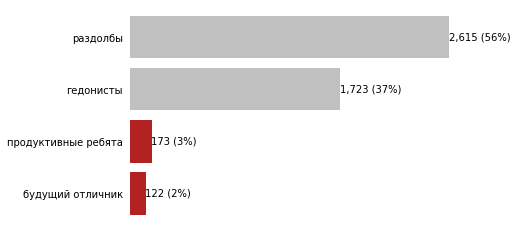

In [85]:
import matplotlib.pyplot as plt

segments_counts = full_data['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['будущий отличник', 'продуктивные ребята']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

Больше всего оказалось раздолбов, меньше всего - будущих отличников :)
